In [1]:
# load in libraries 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.api import VAR, VARMAX

## Model 1:

In [3]:
# load in data and set DATE column to index
df = pd.read_csv('../data/complete_final_data.csv', parse_dates=['DATE'], index_col=['DATE'])

In [4]:
# create a list of our target columns to use as endogenous features
target = ['target_retail','target_mining_logging', 'target_construction', 'target_edu_health',
       'target_manufacturing', 'target_prof_business', 'target_gov',
       'target_leisure_hospitality']

In [5]:
# create new df to hold exogenous features
exog = df.drop(columns=target)
exog

,avg_weeks_unemployed,cont_claims_insur_unemploy,full_employ_level,part_employ_level,not_in_labor_force,gov_unemp_insur,labor_particip_women,labor_particip_men,labor_particip_total,real_estate_loans,...,m1_real,unemp_less_five_weeks,unemp_5_to_14_wks,unemp_15_to_26_wks,unemp_over_27_wks,personal_consum_exp,personal_save_rate,emp_pop_ratio,unemploy_rate,insured_unemploy_rate
DATE,,,,,,,,,,,,,,,,,,,,,
1975-01-01,10.7,3619250.0,85627.0,4133.0,58627.0,12.0,46.3,78.3,61.4,130.0257,...,523.7,3293.0,2646.0,930.0,625.0,975.6,13.2,56.4,8.1,5.500
1975-02-01,11.7,3856500.0,85256.0,3994.0,59214.0,14.0,45.9,78.0,61.0,130.6318,...,522.8,2947.0,2616.0,1124.0,717.0,989.4,12.5,56.1,8.1,5.875
1975-03-01,11.8,4175200.0,85187.0,4087.0,59052.0,16.5,46.2,78.0,61.2,131.1786,...,523.5,3193.0,2630.0,1305.0,769.0,990.6,12.7,56.0,8.6,6.340
1975-04-01,12.9,4473500.0,85189.0,4179.0,59044.0,18.8,46.3,78.1,61.3,131.6391,...,521.1,2915.0,2719.0,1478.0,964.0,995.0,14.2,55.9,8.8,6.750
1975-05-01,13.4,4578200.0,85451.0,3972.0,58820.0,19.6,46.4,78.3,61.5,131.7233,...,525.8,3051.0,2692.0,1554.0,1089.0,1018.9,17.3,56.0,9.0,6.880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,21.4,7942600.0,149669.0,6668.0,100207.0,304.3,55.8,67.7,61.6,4680.5019,...,2143.7,2494.0,2341.0,2651.0,3534.0,14627.1,13.1,57.4,6.9,5.400
2020-11-01,23.0,5941750.0,149809.0,6641.0,100548.0,280.8,55.9,67.4,61.5,4667.5872,...,2318.7,2455.0,2404.0,1875.0,3929.0,14532.8,12.5,57.4,6.7,4.050
2020-12-01,23.4,5274750.0,149830.0,6170.0,100663.0,304.3,55.9,67.4,61.5,4659.1834,...,2528.7,2904.0,2222.0,1572.0,3956.0,14451.1,13.5,57.4,6.7,3.600


#### Much of the code below was borrowed from: https://towardsdatascience.com/future-price-prediction-beyond-test-data-using-vector-auto-regression-eedb7e0c04e

In [6]:
# create new dataframe to hold endogenous/target features
targets = df[target]

df_sc = targets
df_sc

,target_retail,target_mining_logging,target_construction,target_edu_health,target_manufacturing,target_prof_business,target_gov,target_leisure_hospitality
DATE,,,,,,,,
1975-01-01,8518.9,789,3841,5404,17344,6006,14624,5476
1975-02-01,8528.5,790,3718,5421,17004,6002,14747,5484
1975-03-01,8526.7,793,3628,5430,16853,5999,14754,5488
1975-04-01,8492.9,785,3565,5435,16759,5994,14795,5472
1975-05-01,8538.5,799,3552,5468,16746,6022,14827,5502
...,...,...,...,...,...,...,...,...
2020-10-01,15131.8,594,7329,23235,12155,20296,21583,13622
2020-11-01,15129.7,597,7353,23278,12196,20391,21488,13632
2020-12-01,15159.8,597,7400,23249,12231,20550,21456,13134


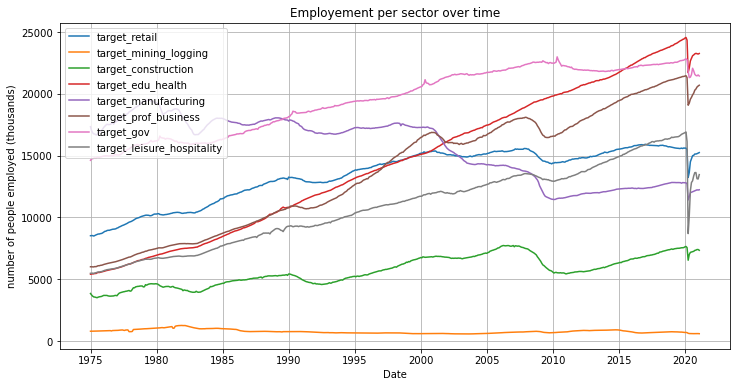

In [7]:
# plot the target columns
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(df_sc)
plt.legend(df_sc.columns)
plt.title('Employement per sector over time')
plt.ylabel('number of people employed (thousands)')
plt.xlabel('Date')
plt.show();

In [8]:
# function that computes the augmented Dickey–Fuller test for each column
# this is done to determine if the data is stationary
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    print()
    print(f'Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
    
        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the   Null Hypothesis.")
            print(f" => Series is Non-Stationary.")
    
# ADF test on each column
for name, column in targets.iteritems():
    adfuller_test(column, name = column.name)


Augmented Dickey-Fuller Test on "target_retail" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -3.1461
No. Lags Chosen = 4
 Critical value 1%     = -3.442
 => P-Value = 0.0233. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.867
 => P-Value = 0.0233. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.57
 => P-Value = 0.0233. Rejecting Null Hypothesis.
 => Series is Stationary.

Augmented Dickey-Fuller Test on "target_mining_logging" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -1.6824
No. Lags Chosen = 10
 Critical value 1%     = -3.442
 => P-Value = 0.4402. Weak evidence to reject the   Null Hypothesis.
 => Series is Non-Stationary.
 Critical value 5%     = -2.867
 => P-Value = 0.4402. Weak evidence to reject the   Null

In [9]:
# differenced target columns
data_diff = df_sc.diff()
data_diff.dropna(inplace=True)
print('Glimpse of differenced data:')
print(data_diff.head())

Glimpse of differenced data:
            target_retail  target_mining_logging  target_construction  \
DATE                                                                    
1975-02-01            9.6                    1.0               -123.0   
1975-03-01           -1.8                    3.0                -90.0   
1975-04-01          -33.8                   -8.0                -63.0   
1975-05-01           45.6                   14.0                -13.0   
1975-06-01           44.4                    3.0                -26.0   

            target_edu_health  target_manufacturing  target_prof_business  \
DATE                                                                        
1975-02-01               17.0                -340.0                  -4.0   
1975-03-01                9.0                -151.0                  -3.0   
1975-04-01                5.0                 -94.0                  -5.0   
1975-05-01               33.0                 -13.0                  28.0 

In [10]:
# difference exogenious columns
exog_diff = exog.diff()
exog_diff.dropna(inplace=True)
print('Glimpse of differenced data:')
print(exog_diff.head())

Glimpse of differenced data:
            avg_weeks_unemployed  cont_claims_insur_unemploy  \
DATE                                                           
1975-02-01                   1.0                    237250.0   
1975-03-01                   0.1                    318700.0   
1975-04-01                   1.1                    298300.0   
1975-05-01                   0.5                    104700.0   
1975-06-01                   1.9                   -200950.0   

            full_employ_level  part_employ_level  not_in_labor_force  \
DATE                                                                   
1975-02-01             -371.0             -139.0               587.0   
1975-03-01              -69.0               93.0              -162.0   
1975-04-01                2.0               92.0                -8.0   
1975-05-01              262.0             -207.0              -224.0   
1975-06-01              -96.0             -198.0               580.0   

            gov_u

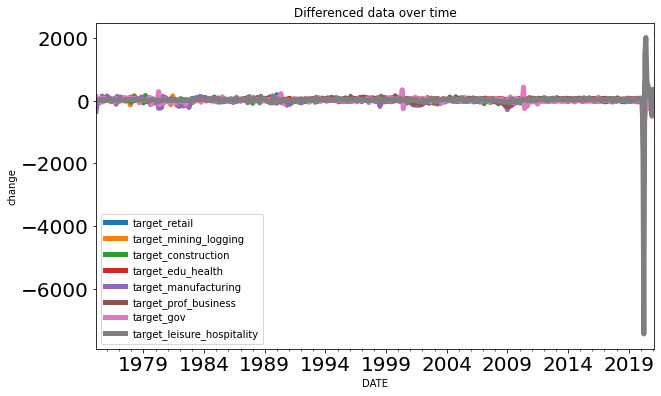

In [12]:
# plotting differenced data
data_diff.plot(figsize=(10,6), linewidth=5, fontsize=20)
plt.title('Differenced data over time')
plt.ylabel('change');


plt.savefig('../assets/diff_data.png',bbox_inches='tight')

In [13]:
# ADF Test on each column
for name, column in data_diff.iteritems():
    adfuller_test(column, name=column.name)


Augmented Dickey-Fuller Test on "target_retail" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -14.1004
No. Lags Chosen = 3
 Critical value 1%     = -3.442
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.867
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

Augmented Dickey-Fuller Test on "target_mining_logging" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -5.9219
No. Lags Chosen = 9
 Critical value 1%     = -3.442
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.867
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10% 

In [14]:
# create the model on the stationary data
model = VAR(data_diff, exog=exog_diff)

C:\Users\DanielPrestonMc\anaconda3\envs\dsi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [15]:
# determine how many lags should be used when fitting the model
res = model.select_order(maxlags=15)

res.summary()

,AIC,BIC,FPE,HQIC
0,56.42,57.89,3.192e+24,57.00
1,55.55,57.53*,1.335e+24,56.32
2,55.06,57.55,8.198e+23,56.03
3,54.94,57.94,7.278e+23,56.11
4,54.59,58.10,5.145e+23,55.96
5,54.50,58.52,4.721e+23,56.07
6,54.23,58.76,3.619e+23,56.00
7,54.07,59.11,3.094e+23,56.04
8,53.69,59.24,2.124e+23,55.86*
9,53.65*,59.71,2.060e+23*,56.02


In [16]:
# fits the model with 9 lags and criterion Akaike
results = model.fit(maxlags=9, ic='aic')

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     15:45:06
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    59.5999
Nobs:                     544.000    HQIC:                   55.9421
Log likelihood:          -19992.8    FPE:                1.94148e+23
AIC:                      53.5940    Det(Omega_mle):     5.35694e+22
--------------------------------------------------------------------
Results for equation target_retail
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                17.092273         5.014460            3.409           0.001
avg_weeks_unemployed                 -1.483469         2.351225           -0.631     

In [17]:
len(results.endog)

553

In [18]:
len(results.exog)

553

In [19]:
nobs = 12 # number of future steps to predict

# creates predictions for target variables of step nobs and puts them into a dataframe
pred = results.forecast(y=results.endog, steps=nobs, exog_future=results.exog[-nobs:])
pred = pd.DataFrame(pred, columns=df_sc.columns+'_preds')
pred

,target_retail_preds,target_mining_logging_preds,target_construction_preds,target_edu_health_preds,target_manufacturing_preds,target_prof_business_preds,target_gov_preds,target_leisure_hospitality_preds
0,-136.616600,-25.248522,-75.119733,-228.025738,44.949381,-103.826835,-54.969123,-804.806420
1,-2165.268481,-65.855923,-1018.631284,-2582.157846,-1206.707635,-2106.076097,-934.372667,-7306.406661
2,410.551915,-13.580372,465.476294,365.499516,275.447489,207.456917,-400.517823,1419.963108
3,876.471540,12.804549,221.133368,527.673123,364.620284,414.900314,-107.151178,2058.635557
4,234.227793,8.065188,20.153243,150.094185,108.078070,170.849429,172.200547,629.316591
5,303.564260,-5.305024,18.915357,197.817501,68.504329,246.938289,422.846563,227.213850
6,57.566800,6.149593,-0.191714,39.589276,24.904429,172.071047,-221.626916,377.220747
7,112.756507,14.871340,102.183239,69.683507,36.549780,271.757137,-241.050177,303.261370
8,19.381115,-9.023411,54.825210,36.190001,79.493260,169.238744,-140.335517,24.456797
9,54.455249,2.954511,37.627172,-46.580328,40.273013,186.347596,-45.314639,-484.643393


In [20]:
# creates function to revese the differentiated data
def invert_transformation(pred):
    forecast = pred.copy()
    columns = targets.columns

    for col in columns:
        forecast[col+'_preds'] = forecast[col +'_preds'].cumsum() + targets[col].iloc[-1]

    return forecast



output = invert_transformation(pred)

# Print out whichever target column predictions you want here
output_df = pd.DataFrame(output)
print(output_df)

    target_retail_preds  target_mining_logging_preds  \
0          15110.583400                   563.751478   
1          12945.314919                   497.895555   
2          13355.866834                   484.315183   
3          14232.338373                   497.119732   
4          14466.566166                   505.184920   
5          14770.130427                   499.879896   
6          14827.697227                   506.029489   
7          14940.453734                   520.900829   
8          14959.834849                   511.877418   
9          15014.290097                   514.831929   
10         15065.899957                   520.027279   
11         15125.393351                   520.306492   

    target_construction_preds  target_edu_health_preds  \
0                 7264.880267             23038.974262   
1                 6246.248982             20456.816416   
2                 6711.725276             20822.315932   
3                 6932.858644          

In [21]:
# adds predictions and target columns together with updated index
d = targets.tail(nobs)

d.reset_index(inplace = True)

d = d.append(pd.DataFrame(
    {'Date': pd.date_range(start = d.DATE.iloc[-1],
        periods = (len(d)+1),
        freq = 'M',
        closed = 'right')
    }))

d.set_index('Date', inplace=True)
d = d.tail(nobs)
output_df.index = d.index
print(output_df)

            target_retail_preds  target_mining_logging_preds  \
Date                                                           
2021-03-31         15110.583400                   563.751478   
2021-04-30         12945.314919                   497.895555   
2021-05-31         13355.866834                   484.315183   
2021-06-30         14232.338373                   497.119732   
2021-07-31         14466.566166                   505.184920   
2021-08-31         14770.130427                   499.879896   
2021-09-30         14827.697227                   506.029489   
2021-10-31         14940.453734                   520.900829   
2021-11-30         14959.834849                   511.877418   
2021-12-31         15014.290097                   514.831929   
2022-01-31         15065.899957                   520.027279   
2022-02-28         15125.393351                   520.306492   

            target_construction_preds  target_edu_health_preds  \
Date                                 

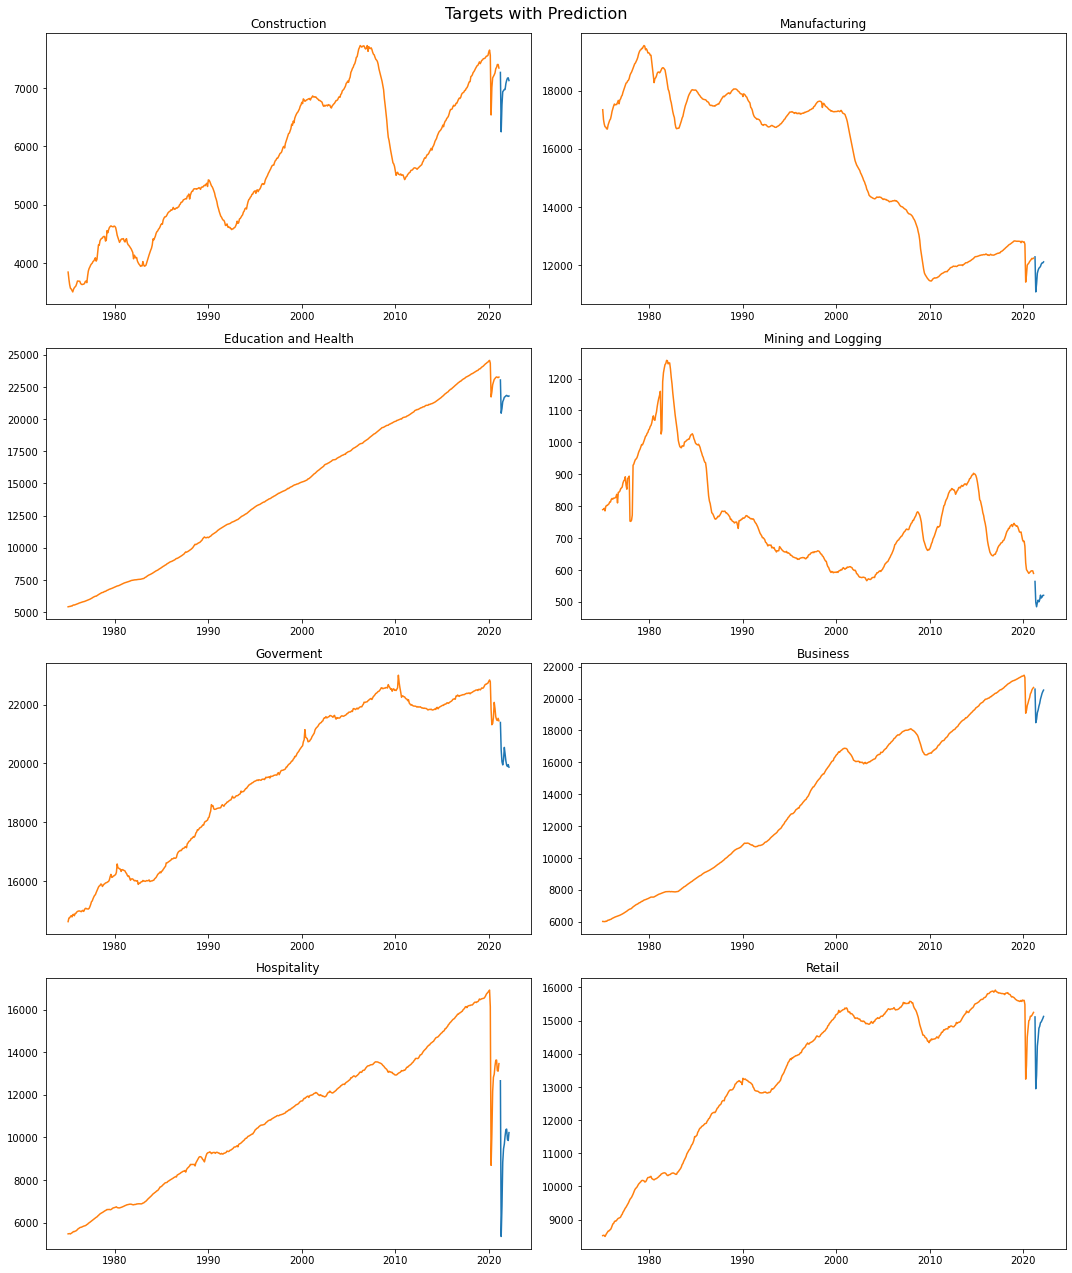

In [23]:

fig,axs = plt.subplots(4,2)

fig.set_figheight(18)
fig.set_figwidth(15)
fig.suptitle('Targets with Prediction', fontsize=16)

axs[0,0].plot(output_df['target_construction_preds'])
axs[0,0].plot(targets['target_construction'])
axs[0,0].title.set_text('Construction')

axs[1,0].plot(output_df['target_edu_health_preds'])
axs[1,0].plot(targets['target_edu_health'])
axs[1,0].title.set_text('Education and Health')

axs[2,0].plot(output_df['target_gov_preds'])
axs[2,0].plot(targets['target_gov'])
axs[2,0].title.set_text('Goverment')

axs[3,0].plot(output_df['target_leisure_hospitality_preds'])
axs[3,0].plot(targets['target_leisure_hospitality'])
axs[3,0].title.set_text('Hospitality')

axs[0,1].plot(output_df['target_manufacturing_preds'])
axs[0,1].plot(targets['target_manufacturing'])
axs[0,1].title.set_text('Manufacturing')

axs[1,1].plot(output_df['target_mining_logging_preds'])
axs[1,1].plot(targets['target_mining_logging'])
axs[1,1].title.set_text('Mining and Logging')

axs[2,1].plot(output_df['target_prof_business_preds'])
axs[2,1].plot(targets['target_prof_business'])
axs[2,1].title.set_text('Business')

axs[3,1].plot(output_df['target_retail_preds'])
axs[3,1].plot(targets['target_retail'])
axs[3,1].title.set_text('Retail')

plt.tight_layout();

plt.savefig('../assets/preds.png',bbox_inches='tight')

# Model 2

In [25]:
df_pct = pd.read_csv('../data/complete_final_data.csv', parse_dates=['DATE'], index_col=['DATE'])

target = ['target_retail','target_mining_logging', 'target_construction', 'target_edu_health',
       'target_manufacturing', 'target_prof_business', 'target_gov',
       'target_leisure_hospitality']


exog_pct = df_pct.drop(columns=target)

exog_pct = exog_pct.iloc[1:,:]
targets_pct = df_pct[target].pct_change()
targets_pct.dropna(inplace = True)

df_sc_pct = targets_pct

In [26]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    print()
    print(f'Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
    
        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the   Null Hypothesis.")
            print(f" => Series is Non-Stationary.")
    
# ADF test on each column
for name, column in targets_pct.iteritems():
    adfuller_test(column, name = column.name)


Augmented Dickey-Fuller Test on "target_retail" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -3.9702
No. Lags Chosen = 11
 Critical value 1%     = -3.442
 => P-Value = 0.0016. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.867
 => P-Value = 0.0016. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.57
 => P-Value = 0.0016. Rejecting Null Hypothesis.
 => Series is Stationary.

Augmented Dickey-Fuller Test on "target_mining_logging" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -5.6236
No. Lags Chosen = 8
 Critical value 1%     = -3.442
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.867
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical v

In [27]:
data_diff_pct = df_sc_pct.diff()
data_diff_pct.dropna(inplace=True)
print('Glimpse of differenced data:')
print(data_diff_pct.head())

Glimpse of differenced data:
            target_retail  target_mining_logging  target_construction  \
DATE                                                                    
1975-03-01      -0.001338               0.002530             0.007816   
1975-04-01      -0.003753              -0.013886             0.006842   
1975-05-01       0.009333               0.027923             0.013718   
1975-06-01      -0.000169              -0.014080            -0.003673   
1975-07-01      -0.001425              -0.003755             0.000230   

            target_edu_health  target_manufacturing  target_prof_business  \
DATE                                                                        
1975-03-01          -0.001486              0.010723              0.000166   
1975-04-01          -0.000739              0.003303             -0.000334   
1975-05-01           0.005151              0.004802              0.005505   
1975-06-01          -0.007901             -0.002568             -0.006498 

In [28]:
exog_diff_pct = exog_pct.diff()
exog_diff_pct.dropna(inplace=True)
print('Glimpse of differenced data:')
print(exog_diff_pct.head())

Glimpse of differenced data:
            avg_weeks_unemployed  cont_claims_insur_unemploy  \
DATE                                                           
1975-03-01                   0.1                    318700.0   
1975-04-01                   1.1                    298300.0   
1975-05-01                   0.5                    104700.0   
1975-06-01                   1.9                   -200950.0   
1975-07-01                  -0.3                   -232500.0   

            full_employ_level  part_employ_level  not_in_labor_force  \
DATE                                                                   
1975-03-01              -69.0               93.0              -162.0   
1975-04-01                2.0               92.0                -8.0   
1975-05-01              262.0             -207.0              -224.0   
1975-06-01              -96.0             -198.0               580.0   
1975-07-01              539.0             -105.0              -112.0   

            gov_u

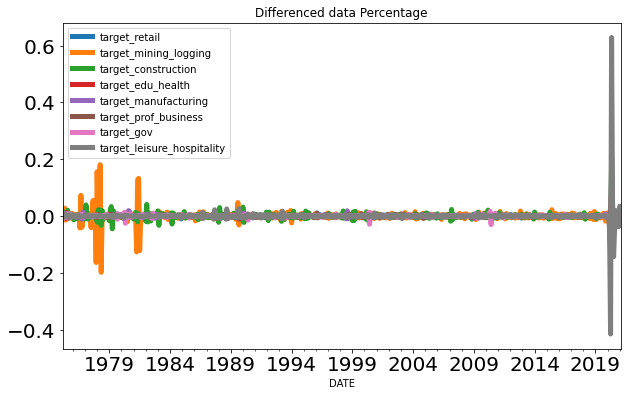

In [30]:
# plotting differenced data
data_diff_pct.plot(figsize=(10,6), linewidth=5, fontsize=20)
plt.title('Differenced data Percentage');

plt.savefig('../assets/diff_data_pct.png',bbox_inches='tight')

In [31]:
model_pct = VAR(data_diff_pct, exog=exog_diff_pct)

res_pct = model_pct.select_order(maxlags=15)

res_pct.summary()

C:\Users\DanielPrestonMc\anaconda3\envs\dsi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,-86.45,-84.98,2.853e-38,-85.88
1,-88.49,-86.51,3.727e-39,-87.71
2,-89.57,-87.08,1.264e-39,-88.59
3,-90.10,-87.10*,7.443e-40,-88.93
4,-90.42,-86.91,5.400e-40,-89.05
5,-90.61,-86.58,4.509e-40,-89.03
6,-90.77,-86.24,3.842e-40,-89.00
7,-91.07,-86.02,2.863e-40,-89.10
8,-91.61,-86.06,1.675e-40,-89.44*
9,-91.67,-85.60,1.596e-40,-89.29


In [32]:
results_pct = model_pct.fit(maxlags=13, ic='aic')

results_pct.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     15:45:48
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -83.9761
Nobs:                     539.000    HQIC:                  -88.8994
Log likelihood:           19708.3    FPE:                1.12022e-40
AIC:                     -92.0621    Det(Omega_mle):     2.06168e-41
--------------------------------------------------------------------
Results for equation target_retail
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  0.000070         0.000173            0.406           0.685
avg_weeks_unemployed                  -0.000205         0.000188           -1.088 

In [33]:
nobs = 10 # number of future steps to predict

pred_pct = results_pct.forecast(y=results_pct.endog, steps=nobs, exog_future=results_pct.exog[-nobs:])
pred_pct = pd.DataFrame(pred_pct, columns=df_sc_pct.columns+'_preds')
pred_pct

,target_retail_preds,target_mining_logging_preds,target_construction_preds,target_edu_health_preds,target_manufacturing_preds,target_prof_business_preds,target_gov_preds,target_leisure_hospitality_preds
0,0.036265,0.202657,0.048413,0.002094,0.046439,0.001805,-0.040268,0.039088
1,0.024083,0.142211,-0.004861,0.078210,0.045779,0.065540,0.023236,-0.040663
2,-0.021971,-0.165576,0.006429,-0.084014,-0.012403,-0.008560,0.012067,0.085397
3,-0.072288,-0.174955,-0.014153,-0.029256,-0.064234,-0.054066,0.004058,-0.256273
4,0.037062,0.016402,-0.021156,0.049420,0.024851,0.011024,-0.004519,0.233528
5,0.032728,0.099876,0.012130,0.023071,0.016701,0.023262,-0.000476,0.097794
6,-0.025816,0.000592,-0.067600,-0.050259,-0.046909,-0.036653,0.015743,-0.170751
7,0.017207,0.066641,0.108789,0.028574,0.042900,0.047385,-0.013712,0.064023
8,0.033140,-0.091875,0.046901,0.009926,0.027453,-0.004663,-0.015633,0.016535
9,-0.048539,0.366931,-0.070590,-0.019333,-0.038134,-0.014167,-0.028762,-0.060546


In [34]:
def invert_transformation(pred, targets):
    forecast = pred.copy()
    columns = targets.columns

    for col in columns:
        forecast[col+'_preds'] = forecast[col +'_preds'].cumsum() + targets[col].iloc[-1]

    return forecast



output_pct = invert_transformation(pred_pct, targets_pct)

# Print out whichever target column predictions you want here
output_pct_df = pd.DataFrame(output_pct)
print(output_pct_df)

   target_retail_preds  target_mining_logging_preds  \
0             0.038968                     0.189257   
1             0.063051                     0.331468   
2             0.041080                     0.165892   
3            -0.031208                    -0.009062   
4             0.005854                     0.007340   
5             0.038582                     0.107216   
6             0.012766                     0.107808   
7             0.029973                     0.174449   
8             0.063114                     0.082574   
9             0.014575                     0.449505   

   target_construction_preds  target_edu_health_preds  \
0                   0.040171                 0.003988   
1                   0.035310                 0.082199   
2                   0.041738                -0.001816   
3                   0.027585                -0.031072   
4                   0.006430                 0.018349   
5                   0.018560                 0.04142

In [35]:
d_pct = targets_pct.tail(nobs)

d_pct.reset_index(inplace = True)

d_pct = d_pct.append(pd.DataFrame(
    {'Date': pd.date_range(start = d_pct.DATE.iloc[-1],
        periods = (len(d_pct)+1),
        freq = 'M',
        closed = 'right')
    }))

d_pct.set_index('Date', inplace=True)
d_pct = d_pct.tail(nobs)
output_pct_df.index = d_pct.index
print(output_pct_df)

            target_retail_preds  target_mining_logging_preds  \
Date                                                           
2021-03-31             0.038968                     0.189257   
2021-04-30             0.063051                     0.331468   
2021-05-31             0.041080                     0.165892   
2021-06-30            -0.031208                    -0.009062   
2021-07-31             0.005854                     0.007340   
2021-08-31             0.038582                     0.107216   
2021-09-30             0.012766                     0.107808   
2021-10-31             0.029973                     0.174449   
2021-11-30             0.063114                     0.082574   
2021-12-31             0.014575                     0.449505   

            target_construction_preds  target_edu_health_preds  \
Date                                                             
2021-03-31                   0.040171                 0.003988   
2021-04-30                   0.03

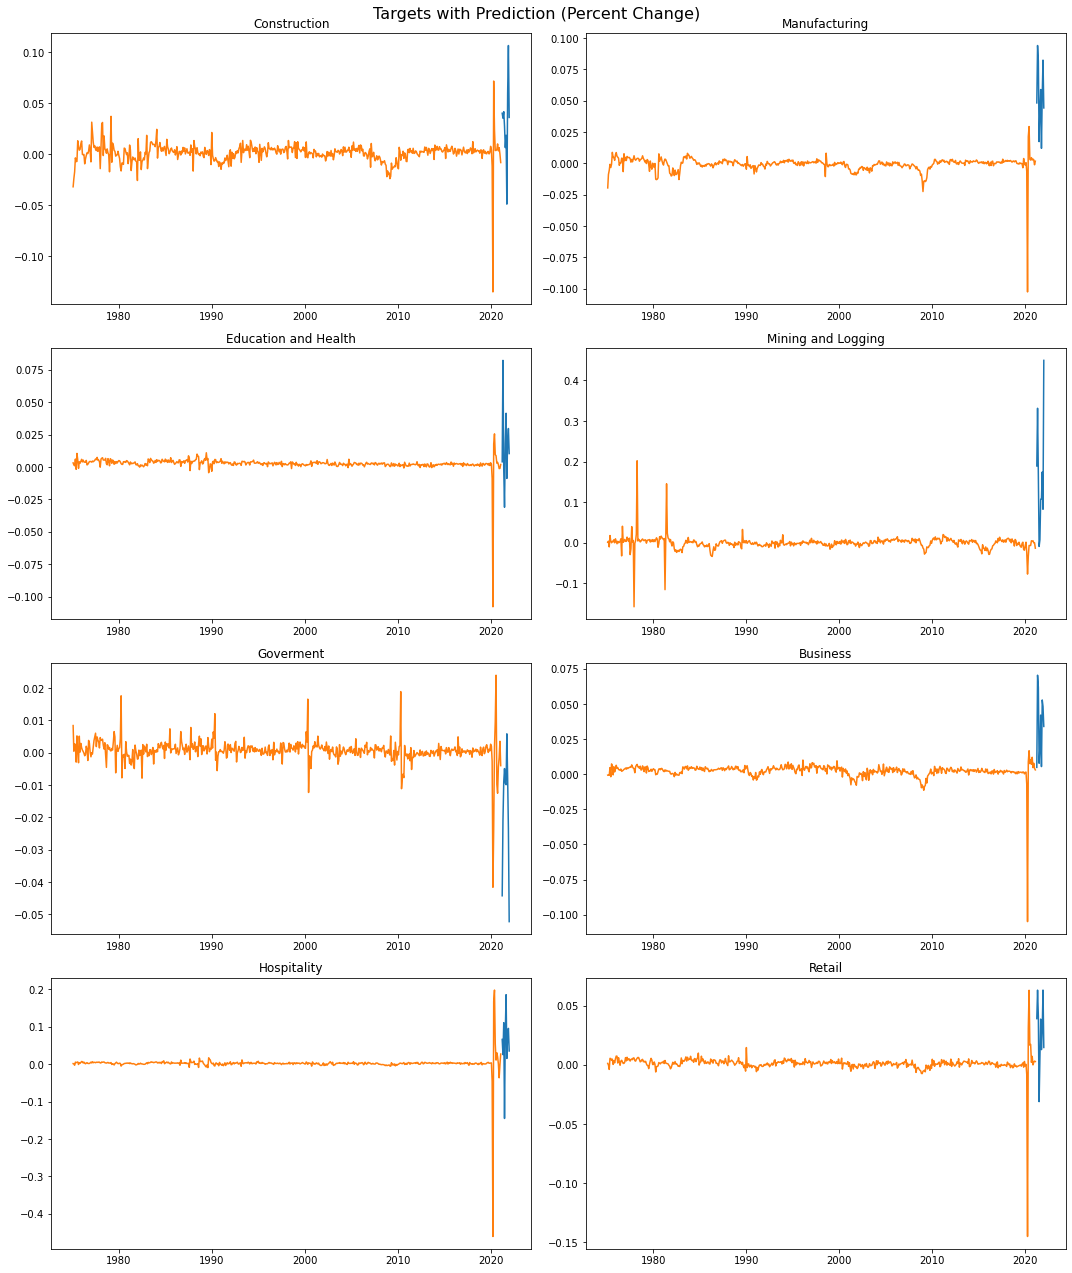

In [37]:
fig,axs = plt.subplots(4,2)

fig.set_figheight(18)
fig.set_figwidth(15)
fig.suptitle('Targets with Prediction (Percent Change)', fontsize=16)

axs[0,0].plot(output_pct_df['target_construction_preds'])
axs[0,0].plot(targets_pct['target_construction'])
axs[0,0].title.set_text('Construction')

axs[1,0].plot(output_pct_df['target_edu_health_preds'])
axs[1,0].plot(targets_pct['target_edu_health'])
axs[1,0].title.set_text('Education and Health')

axs[2,0].plot(output_pct_df['target_gov_preds'])
axs[2,0].plot(targets_pct['target_gov'])
axs[2,0].title.set_text('Goverment')

axs[3,0].plot(output_pct_df['target_leisure_hospitality_preds'])
axs[3,0].plot(targets_pct['target_leisure_hospitality'])
axs[3,0].title.set_text('Hospitality')

axs[0,1].plot(output_pct_df['target_manufacturing_preds'])
axs[0,1].plot(targets_pct['target_manufacturing'])
axs[0,1].title.set_text('Manufacturing')

axs[1,1].plot(output_pct_df['target_mining_logging_preds'])
axs[1,1].plot(targets_pct['target_mining_logging'])
axs[1,1].title.set_text('Mining and Logging')

axs[2,1].plot(output_pct_df['target_prof_business_preds'])
axs[2,1].plot(targets_pct['target_prof_business'])
axs[2,1].title.set_text('Business')

axs[3,1].plot(output_pct_df['target_retail_preds'])
axs[3,1].plot(targets_pct['target_retail'])
axs[3,1].title.set_text('Retail')

plt.tight_layout();

plt.savefig('../assets/preds_pct.png',bbox_inches='tight')

# Model 3:

In [39]:
df_nocov = pd.read_csv('../data/complete_final_data.csv', parse_dates=['DATE'], index_col=['DATE'])

target = ['target_retail','target_mining_logging', 'target_construction', 'target_edu_health',
       'target_manufacturing', 'target_prof_business', 'target_gov',
       'target_leisure_hospitality']

df_nocov = df_nocov.iloc[:542,:]

exog_nocov = df_nocov.drop(columns=target)

targets_nocov = df_nocov[target]

df_sc_nocov = targets_nocov

In [40]:
data_diff_nocov = df_sc_nocov.diff()
data_diff_nocov.dropna(inplace=True)
print('Glimpse of differenced data:')
print(data_diff_nocov.head())

Glimpse of differenced data:
            target_retail  target_mining_logging  target_construction  \
DATE                                                                    
1975-02-01            9.6                    1.0               -123.0   
1975-03-01           -1.8                    3.0                -90.0   
1975-04-01          -33.8                   -8.0                -63.0   
1975-05-01           45.6                   14.0                -13.0   
1975-06-01           44.4                    3.0                -26.0   

            target_edu_health  target_manufacturing  target_prof_business  \
DATE                                                                        
1975-02-01               17.0                -340.0                  -4.0   
1975-03-01                9.0                -151.0                  -3.0   
1975-04-01                5.0                 -94.0                  -5.0   
1975-05-01               33.0                 -13.0                  28.0 

In [41]:
exog_diff_nocov = exog_nocov.diff()
exog_diff_nocov.dropna(inplace=True)
print('Glimpse of differenced data:')
print(exog_diff_nocov.head())

Glimpse of differenced data:
            avg_weeks_unemployed  cont_claims_insur_unemploy  \
DATE                                                           
1975-02-01                   1.0                    237250.0   
1975-03-01                   0.1                    318700.0   
1975-04-01                   1.1                    298300.0   
1975-05-01                   0.5                    104700.0   
1975-06-01                   1.9                   -200950.0   

            full_employ_level  part_employ_level  not_in_labor_force  \
DATE                                                                   
1975-02-01             -371.0             -139.0               587.0   
1975-03-01              -69.0               93.0              -162.0   
1975-04-01                2.0               92.0                -8.0   
1975-05-01              262.0             -207.0              -224.0   
1975-06-01              -96.0             -198.0               580.0   

            gov_u

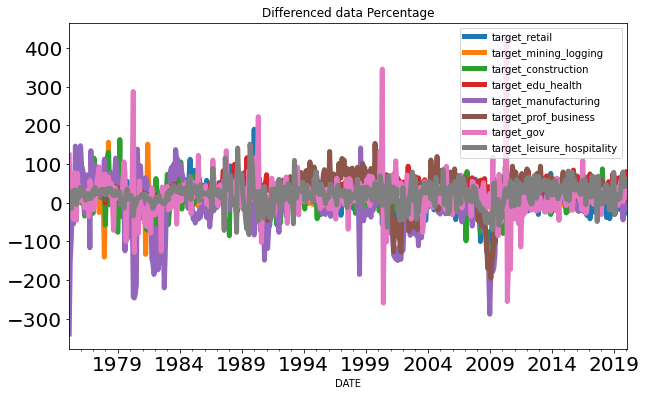

In [43]:
data_diff_nocov.plot(figsize=(10,6), linewidth=5, fontsize=20)
plt.title('Differenced data Percentage');

plt.savefig('../assets/diff_data_nocov.png',bbox_inches='tight')

In [44]:
model_nocov = VAR(data_diff_nocov, exog=exog_diff_nocov)

res_nocov = model_nocov.select_order(maxlags=15)

res_nocov.summary()

C:\Users\DanielPrestonMc\anaconda3\envs\dsi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,53.15,54.64,1.207e+23,53.73
1,52.55,54.56*,6.636e+22,53.34*
2,52.38,54.91,5.636e+22,53.37
3,52.33,55.38,5.337e+22,53.52
4,52.33,55.90,5.350e+22,53.72
5,52.29*,56.38,5.173e+22*,53.89
6,52.32,56.92,5.323e+22,54.12
7,52.33,57.46,5.446e+22,54.34
8,52.37,58.01,5.686e+22,54.58
9,52.47,58.63,6.314e+22,54.88


In [45]:
results_nocov = model_nocov.fit(maxlags=5, ic='aic')

results_nocov.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     15:46:20
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    56.2444
Nobs:                     536.000    HQIC:                   53.7920
Log likelihood:          -19574.3    FPE:                4.79648e+22
AIC:                      52.2160    Det(Omega_mle):     1.97164e+22
--------------------------------------------------------------------
Results for equation target_retail
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                11.079262         4.990854            2.220           0.026
avg_weeks_unemployed                  1.950800         2.152043            0.906     

In [46]:
nobs_nocov = 22 # number of future steps to predict

pred_nocov = results_nocov.forecast(y=results_nocov.endog, steps=nobs_nocov, exog_future=results_nocov.exog[-nobs_nocov:])
pred_nocov = pd.DataFrame(pred_nocov, columns=df_sc_nocov.columns+'_preds')
pred_nocov

,target_retail_preds,target_mining_logging_preds,target_construction_preds,target_edu_health_preds,target_manufacturing_preds,target_prof_business_preds,target_gov_preds,target_leisure_hospitality_preds
0,12.904786,6.169144,23.395886,50.789309,10.543998,33.668470,5.880751,25.121856
1,2.468454,1.104081,23.243731,47.227524,3.688060,17.976292,58.426394,32.128920
2,18.691693,-3.261033,31.961971,42.318980,11.438854,31.353049,-5.371582,32.015100
3,-4.397329,-4.782887,11.231180,50.651795,-3.246467,22.882845,37.987463,25.205511
4,2.323805,-3.247002,26.737521,48.397712,-0.760063,26.415892,25.923214,20.144124
5,0.905028,-0.070639,26.799814,49.288492,5.733184,33.200254,-3.552799,30.733143
6,13.653737,3.822476,24.335745,43.356152,0.486226,23.063205,19.814922,20.640015
7,-21.313913,-5.832416,0.164695,41.890096,1.527771,11.844639,18.504995,19.200232
8,-7.463843,2.466756,16.816629,57.067030,4.408848,1.020283,21.001739,28.227468
9,8.913158,-4.899406,1.940368,34.171044,-2.624663,25.893834,-7.137499,23.025623


In [47]:
output_nocov = invert_transformation(pred_nocov, targets_nocov)

# Print out whichever target column predictions you want here
output_nocov_df = pd.DataFrame(output_nocov)
print(output_nocov_df)

    target_retail_preds  target_mining_logging_preds  \
0          15622.704786                   696.169144   
1          15625.173239                   697.273225   
2          15643.864932                   694.012192   
3          15639.467603                   689.229305   
4          15641.791408                   685.982303   
5          15642.696436                   685.911664   
6          15656.350173                   689.734140   
7          15635.036260                   683.901724   
8          15627.572417                   686.368480   
9          15636.485575                   681.469074   
10         15641.404629                   681.731652   
11         15646.780530                   682.370086   
12         15655.092926                   679.637444   
13         15656.854641                   674.449050   
14         15672.661220                   670.265401   
15         15690.773202                   675.956372   
16         15692.469336                   672.02

In [48]:
d_nocov = targets_nocov.tail(nobs_nocov)

d_nocov.reset_index(inplace = True)

d_nocov = d_nocov.append(pd.DataFrame(
    {'Date': pd.date_range(start = d_nocov.DATE.iloc[-1],
        periods = (len(d_nocov)+1),
        freq = 'M',
        closed = 'right')
    }))

d_nocov.set_index('Date', inplace=True)
d_nocov = d_nocov.tail(nobs_nocov)
output_nocov_df.index = d_nocov.index
print(output_nocov_df)

            target_retail_preds  target_mining_logging_preds  \
Date                                                           
2020-03-31         15622.704786                   696.169144   
2020-04-30         15625.173239                   697.273225   
2020-05-31         15643.864932                   694.012192   
2020-06-30         15639.467603                   689.229305   
2020-07-31         15641.791408                   685.982303   
2020-08-31         15642.696436                   685.911664   
2020-09-30         15656.350173                   689.734140   
2020-10-31         15635.036260                   683.901724   
2020-11-30         15627.572417                   686.368480   
2020-12-31         15636.485575                   681.469074   
2021-01-31         15641.404629                   681.731652   
2021-02-28         15646.780530                   682.370086   
2021-03-31         15655.092926                   679.637444   
2021-04-30         15656.854641         

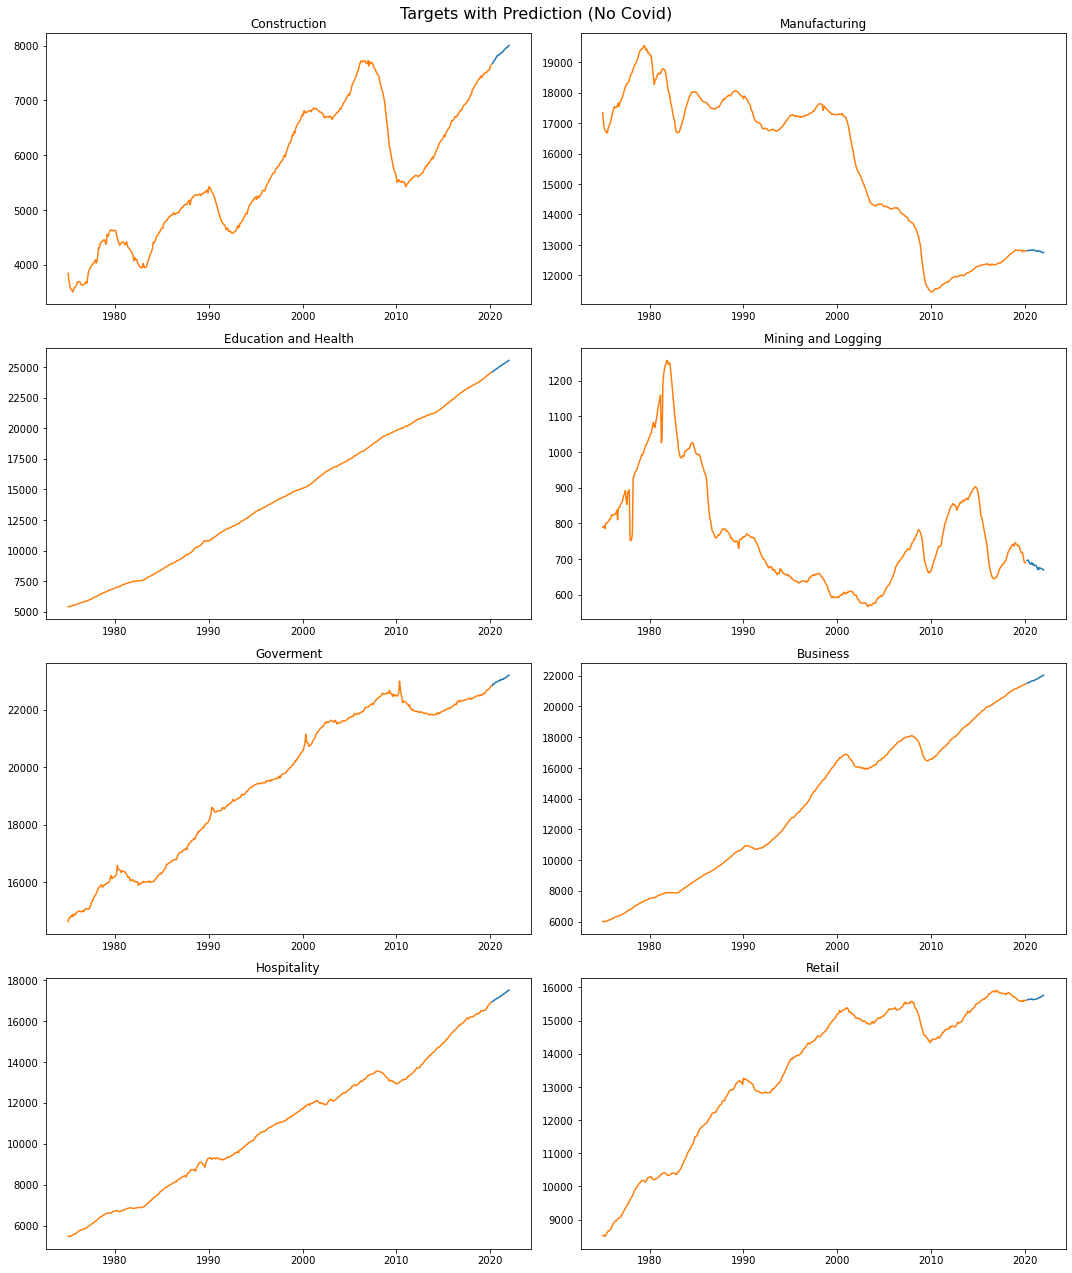

In [50]:
fig,axs = plt.subplots(4,2)

fig.set_figheight(18)
fig.set_figwidth(15)
fig.suptitle('Targets with Prediction (No Covid)', fontsize=16)


axs[0,0].plot(output_nocov_df['target_construction_preds'])
axs[0,0].plot(targets_nocov['target_construction'])
axs[0,0].title.set_text('Construction')

axs[1,0].plot(output_nocov_df['target_edu_health_preds'])
axs[1,0].plot(targets_nocov['target_edu_health'])
axs[1,0].title.set_text('Education and Health')

axs[2,0].plot(output_nocov_df['target_gov_preds'])
axs[2,0].plot(targets_nocov['target_gov'])
axs[2,0].title.set_text('Goverment')

axs[3,0].plot(output_nocov_df['target_leisure_hospitality_preds'])
axs[3,0].plot(targets_nocov['target_leisure_hospitality'])
axs[3,0].title.set_text('Hospitality')

axs[0,1].plot(output_nocov_df['target_manufacturing_preds'])
axs[0,1].plot(targets_nocov['target_manufacturing'])
axs[0,1].title.set_text('Manufacturing')

axs[1,1].plot(output_nocov_df['target_mining_logging_preds'])
axs[1,1].plot(targets_nocov['target_mining_logging'])
axs[1,1].title.set_text('Mining and Logging')

axs[2,1].plot(output_nocov_df['target_prof_business_preds'])
axs[2,1].plot(targets_nocov['target_prof_business'])
axs[2,1].title.set_text('Business')

axs[3,1].plot(output_nocov_df['target_retail_preds'])
axs[3,1].plot(targets_nocov['target_retail'])
axs[3,1].title.set_text('Retail')

plt.tight_layout();

plt.savefig('../assets/preds_nocov.png',bbox_inches='tight')

# Model 4

In [52]:
df_nocov_pct = pd.read_csv('../data/complete_final_data.csv', parse_dates=['DATE'], index_col=['DATE'])

target = ['target_retail','target_mining_logging', 'target_construction', 'target_edu_health',
       'target_manufacturing', 'target_prof_business', 'target_gov',
       'target_leisure_hospitality']

df_nocov_pct = df_nocov_pct.iloc[:542,:]

exog_nocov_pct = df_nocov_pct.drop(columns=target)
exog_nocov_pct = exog_nocov_pct.iloc[1:,:]

targets_nocov_pct = df_nocov_pct[target].pct_change()
targets_nocov_pct.dropna(inplace = True)

df_sc_nocov_pct = targets_nocov_pct

In [53]:
data_diff_nocov_pct = df_sc_nocov_pct.diff()
data_diff_nocov_pct.dropna(inplace=True)
print('Glimpse of differenced data:')
print(data_diff_nocov_pct.head())

Glimpse of differenced data:
            target_retail  target_mining_logging  target_construction  \
DATE                                                                    
1975-03-01      -0.001338               0.002530             0.007816   
1975-04-01      -0.003753              -0.013886             0.006842   
1975-05-01       0.009333               0.027923             0.013718   
1975-06-01      -0.000169              -0.014080            -0.003673   
1975-07-01      -0.001425              -0.003755             0.000230   

            target_edu_health  target_manufacturing  target_prof_business  \
DATE                                                                        
1975-03-01          -0.001486              0.010723              0.000166   
1975-04-01          -0.000739              0.003303             -0.000334   
1975-05-01           0.005151              0.004802              0.005505   
1975-06-01          -0.007901             -0.002568             -0.006498 

In [54]:
exog_diff_nocov_pct = exog_nocov_pct.diff()
exog_diff_nocov_pct.dropna(inplace=True)
print('Glimpse of differenced data:')
print(exog_diff_nocov_pct.head())

Glimpse of differenced data:
            avg_weeks_unemployed  cont_claims_insur_unemploy  \
DATE                                                           
1975-03-01                   0.1                    318700.0   
1975-04-01                   1.1                    298300.0   
1975-05-01                   0.5                    104700.0   
1975-06-01                   1.9                   -200950.0   
1975-07-01                  -0.3                   -232500.0   

            full_employ_level  part_employ_level  not_in_labor_force  \
DATE                                                                   
1975-03-01              -69.0               93.0              -162.0   
1975-04-01                2.0               92.0                -8.0   
1975-05-01              262.0             -207.0              -224.0   
1975-06-01              -96.0             -198.0               580.0   
1975-07-01              539.0             -105.0              -112.0   

            gov_u

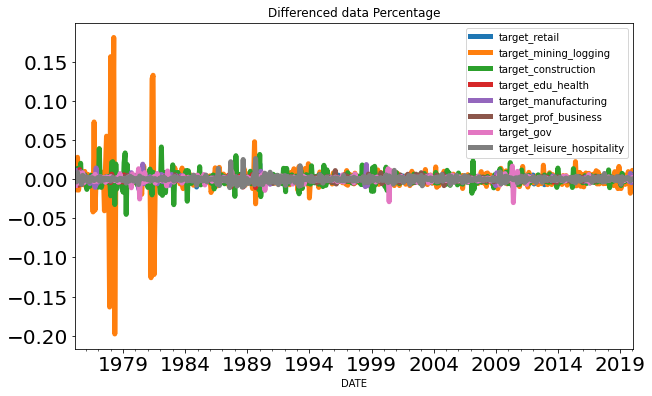

In [56]:
data_diff_nocov_pct.plot(figsize=(10,6), linewidth=5, fontsize=20)
plt.title('Differenced data Percentage');

plt.savefig('../assets/diff_data_nocov_pct.png',bbox_inches='tight')

In [57]:
model_nocov_pct = VAR(data_diff_nocov_pct, exog=exog_diff_nocov_pct)

res_nocov_pct = model_nocov_pct.select_order(maxlags=15)

res_nocov_pct.summary()

C:\Users\DanielPrestonMc\anaconda3\envs\dsi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,-89.07,-87.58,2.074e-39,-88.49
1,-91.15,-89.14,2.597e-40,-90.36
2,-91.93,-89.40*,1.189e-40,-90.94
3,-92.16,-89.10,9.519e-41,-90.96
4,-92.48,-88.90,6.938e-41,-91.08*
5,-92.57,-88.48,6.310e-41,-90.97
6,-92.68,-88.07,5.669e-41,-90.88
7,-92.79,-87.66,5.117e-41,-90.78
8,-92.78,-87.13,5.185e-41,-90.57
9,-92.73,-86.55,5.539e-41,-90.31


In [58]:
results_nocov_pct = model_nocov_pct.fit(maxlags=13, ic='aic')

results_nocov_pct.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     15:46:51
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -84.8253
Nobs:                     527.000    HQIC:                  -89.8311
Log likelihood:           19552.9    FPE:                4.18446e-41
AIC:                     -93.0520    Det(Omega_mle):     7.43880e-42
--------------------------------------------------------------------
Results for equation target_retail
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.000168         0.000172           -0.973           0.330
avg_weeks_unemployed                   0.000114         0.000174            0.657 

In [59]:
nobs_nocov_pct = 22 # number of future steps to predict

pred_nocov_pct = results_nocov_pct.forecast(y=results_nocov_pct.endog, steps=nobs_nocov_pct, exog_future=results_nocov_pct.exog[-nobs_nocov_pct:])
pred_nocov_pct = pd.DataFrame(pred_nocov_pct, columns=df_sc_nocov_pct.columns+'_preds')
pred_nocov_pct

,target_retail_preds,target_mining_logging_preds,target_construction_preds,target_edu_health_preds,target_manufacturing_preds,target_prof_business_preds,target_gov_preds,target_leisure_hospitality_preds
0,0.000074,0.004304,-0.003334,0.000149,-0.000335,0.000686,-0.000746,-0.000723
1,-0.000999,-0.015784,-0.000099,0.000110,-0.000568,-0.001461,0.002634,-0.001478
2,0.001080,0.008759,0.003329,-0.000348,0.000135,0.000814,-0.003243,0.002475
3,-0.001467,-0.000596,-0.004504,0.000275,-0.000690,-0.000550,0.000972,-0.002144
4,0.000370,-0.013356,0.006671,0.000096,0.000715,0.001134,-0.000351,0.000873
5,0.000335,0.006994,-0.004139,-0.000218,-0.000093,-0.001162,-0.000768,0.000159
6,-0.000335,0.001867,-0.003218,0.000268,-0.000840,-0.000252,0.002562,-0.001315
7,-0.001482,-0.008459,0.000457,-0.000879,-0.000191,-0.001046,-0.001108,-0.000144
8,0.000727,0.009218,0.001017,0.000989,-0.000605,-0.001156,-0.000765,0.001680
9,0.000575,-0.005273,-0.001652,-0.000535,-0.000284,0.002035,-0.000239,0.000118


In [60]:
output_nocov_pct = invert_transformation(pred_nocov_pct, targets_nocov_pct)

# Print out whichever target column predictions you want here
output_nocov_pct_df = pd.DataFrame(output_nocov_pct)
print(output_nocov_pct_df)

    target_retail_preds  target_mining_logging_preds  \
0              0.000369                     0.005755   
1             -0.000630                    -0.010029   
2              0.000450                    -0.001271   
3             -0.001017                    -0.001867   
4             -0.000646                    -0.015223   
5             -0.000311                    -0.008229   
6             -0.000646                    -0.006362   
7             -0.002128                    -0.014821   
8             -0.001401                    -0.005603   
9             -0.000826                    -0.010876   
10            -0.000355                    -0.007701   
11            -0.000013                    -0.009463   
12            -0.000346                    -0.006865   
13            -0.000642                    -0.010134   
14            -0.000944                    -0.012816   
15            -0.000133                    -0.002778   
16            -0.000840                    -0.00

In [61]:
d_nocov_pct = targets_nocov_pct.tail(nobs_nocov_pct)

d_nocov_pct.reset_index(inplace = True)

d_nocov_pct = d_nocov_pct.append(pd.DataFrame(
    {'Date': pd.date_range(start = d_nocov_pct.DATE.iloc[-1],
        periods = (len(d_nocov_pct)+1),
        freq = 'M',
        closed = 'right')
    }))

d_nocov_pct.set_index('Date', inplace=True)
d_nocov_pct = d_nocov_pct.tail(nobs_nocov_pct)
output_nocov_pct_df.index = d_nocov_pct.index
print(output_nocov_pct_df)

            target_retail_preds  target_mining_logging_preds  \
Date                                                           
2020-03-31             0.000369                     0.005755   
2020-04-30            -0.000630                    -0.010029   
2020-05-31             0.000450                    -0.001271   
2020-06-30            -0.001017                    -0.001867   
2020-07-31            -0.000646                    -0.015223   
2020-08-31            -0.000311                    -0.008229   
2020-09-30            -0.000646                    -0.006362   
2020-10-31            -0.002128                    -0.014821   
2020-11-30            -0.001401                    -0.005603   
2020-12-31            -0.000826                    -0.010876   
2021-01-31            -0.000355                    -0.007701   
2021-02-28            -0.000013                    -0.009463   
2021-03-31            -0.000346                    -0.006865   
2021-04-30            -0.000642         

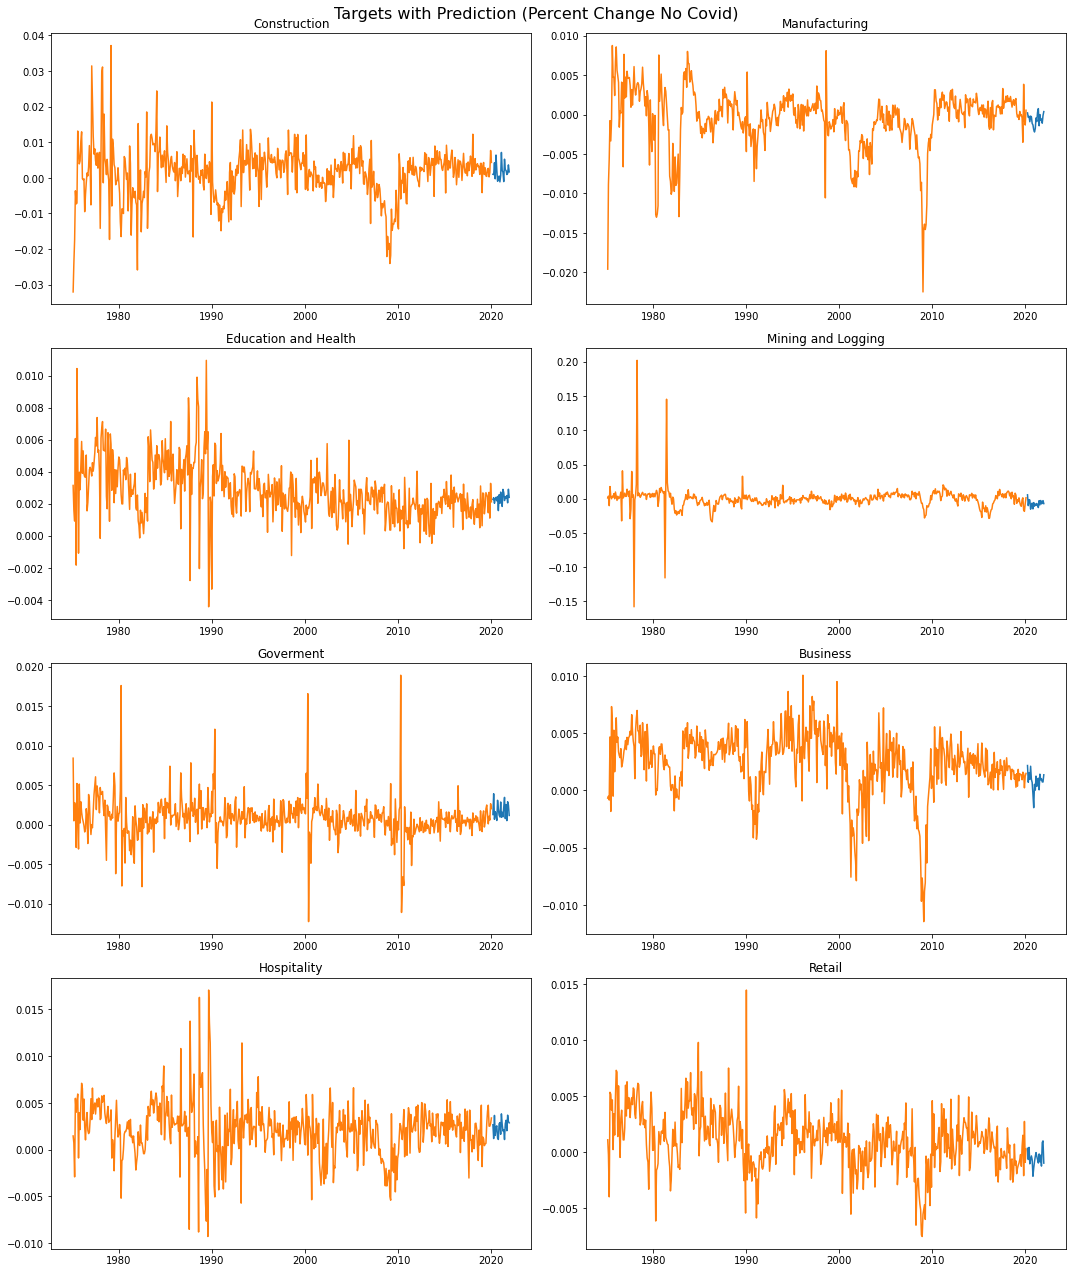

In [63]:
fig,axs = plt.subplots(4,2)

fig.set_figheight(18)
fig.set_figwidth(15)
fig.suptitle('Targets with Prediction (Percent Change No Covid)', fontsize=16)


axs[0,0].plot(output_nocov_pct_df['target_construction_preds'])
axs[0,0].plot(targets_nocov_pct['target_construction'])
axs[0,0].title.set_text('Construction')

axs[1,0].plot(output_nocov_pct_df['target_edu_health_preds'])
axs[1,0].plot(targets_nocov_pct['target_edu_health'])
axs[1,0].title.set_text('Education and Health')

axs[2,0].plot(output_nocov_pct_df['target_gov_preds'])
axs[2,0].plot(targets_nocov_pct['target_gov'])
axs[2,0].title.set_text('Goverment')

axs[3,0].plot(output_nocov_pct_df['target_leisure_hospitality_preds'])
axs[3,0].plot(targets_nocov_pct['target_leisure_hospitality'])
axs[3,0].title.set_text('Hospitality')

axs[0,1].plot(output_nocov_pct_df['target_manufacturing_preds'])
axs[0,1].plot(targets_nocov_pct['target_manufacturing'])
axs[0,1].title.set_text('Manufacturing')

axs[1,1].plot(output_nocov_pct_df['target_mining_logging_preds'])
axs[1,1].plot(targets_nocov_pct['target_mining_logging'])
axs[1,1].title.set_text('Mining and Logging')

axs[2,1].plot(output_nocov_pct_df['target_prof_business_preds'])
axs[2,1].plot(targets_nocov_pct['target_prof_business'])
axs[2,1].title.set_text('Business')

axs[3,1].plot(output_nocov_pct_df['target_retail_preds'])
axs[3,1].plot(targets_nocov_pct['target_retail'])
axs[3,1].title.set_text('Retail')

plt.tight_layout();

plt.savefig('../assets/preds_nocov_pct.png',bbox_inches='tight')